# Steel Defect Detection, Classification, and Segmentation

By Reynaldo Vazquez <br>
March 2021

<br>

This notebooks presents a solution to the [Severstal: Steel Defect Detection]( https://www.kaggle.com/c/severstal-steel-defect-detection) competition. The challenge consists on using images to detect defects on pieces of steel, classify the type of defect (4 types), and identify the location and area of the defect.

<h3>The solution consists on a two-step approach.</h3>

1. The first step is to run the images through an ensemble of binary image neural network classifiers to determine whether the piece of steel in the image presents a  defect.

2. The second step, runs the same image through an ensemble of segmentation neural networks to identify the location of the defect and identify the type of the defect. Images may contain no defects or 1 or more types of defects. Although the bulk of defect examples contain 1 type of defect.  

This approach achieves a [Dice coefficient of 0.90229](https://www.kaggle.com/reyvaz/severstal-inference-submission?scriptVersionId=59142554) in Severstal's private test data, on par with the top 3% of the results.


In [ ]:
#@markdown Class + Mask Prediction Examples
%%html
<div style = "max-width:900px" align="center">
<iframe src="https://rexvaz.com/files/steel_defects/slides.html" width="100%" height="320" 
frameBorder="0"></iframe>
</div>

<h2> Data </h2>

To train using TPUs, I organized the original training data consisting of images in JPG format, and metadata in a CSV file, into sharded TFRec files. The original JPG and CSV data can be found [here]( https://www.kaggle.com/c/severstal-steel-defect-detection/data). The TFRecs created for this solution can be found [here]( https://www.kaggle.com/reyvaz/tfrecs-for-severstal-steel-defect-detection), along with detailed description of the contents and parsing instructions. 

<br>
<h2> Training and Evaluation </h2>

All 1st and 2nd step neural networks were trained on a K = 5, K-Fold cross-validation distribution of the data, all with the same image size. Random data augmentations were applied to the training partition data for all networks and folds in both stages. Data augmentation was not applied for neither validation or at testing time. 

<h3> Binary Classification </h3>

The ensemble for the binary classification step consists of EfficientNet (Tan & Le 2020) based classifiers versions B0-B5. The classifiers were selected according to their out-of-fold (i.e. fold validation) performance. The metric optimized for this task was accuracy on the full out-of-fold data for each fold.

Although there’s no official labeled test set for this task, out-of-fold accuracy was ~0.98 across folds. Adjustment of the classification thresholds could achieve > 0.99 accuracy, (sensitivity > 0.99 and specificity ~ 0.99) while rendering less than 2 percent of the results inconclusive. 

An experiment using validation data aimed at minimizing false negatives, likely the most crucial goal in terms of quality control, was able to reduce the number of false negatives to 1, while only unable to classify about 10 percent of observations. The full results of the experiment are shown below.



In [ ]:
#@markdown Performance Report
from urllib import request
from IPython.display import display, HTML
resp = request.urlopen('https://rexvaz.com/files/steel_defects/p-report.html')
p_source = resp.read().decode('utf-8')
display(HTML(p_source))

Although these results are overfit to the corresponding validation data, it sheds some light on the potential usefulness of the binary classification model in terms of quality control. 

<h3> Defect Type Classification and Segmentation </h3>

The ensemble for the 2nd step consists of UNet++ (Zhou et al., 2019) based CNNs, all with EfficientNet backbones versions B0-B5. The networks included in the ensemble were selected according to their out-of-fold performance on validation data on images with defects. 

The metric used here was the Dice coefficient. The formula to calculate the Dice coefficient is given by:

$$
\begin{align*}
\text{Dice coefficient} = \frac{2|\hat{Y} \cap Y|}{|\hat{Y}| + |Y|}
\end{align*}
$$

where $\hat{Y}$ is the predicted set of pixels and $Y$ is the ground truth.

During training, the overall Dice coefficient was calculated in 3 ways: 
1.	<u>Batch-wise average</u> was used for tracking purposes but also for back propagation as part of the Dice based losses.
2.	<u>Image-wise average</u> was the metric chosen to be maximized during training; it provided the most stable and consistent way to compare performance across different specifications.
3.	<u>Channel-wise average</u> (i.e. Dice coefficient was calculated for each type of defect for each image and averaged across examples). This is the official metric used in the competition and it is the metric that can be compared to other works; it was monitored and reported throughout training. It is also the metric reported in the Segmentation Evaluation section below.

Images with no defects were included only in the training partitions and were heavily under-sampled; only a random sample of ~10 percent of these were used each epoch. Also, images with the less common types of defects (type 1, 2 and 4) were over-sampled at rates according to their frequency in the data. 

For this step, images with no defects were completely excluded from validation at training time, and images with defects were used only once (i.e. no over-sampling). 

<br>
<h2> Acknowledgements: </h2>

- Thanks to [PAO Severstal](https://www.severstal.com/) for providing the dataset.

- This project was originally inspired by the Kaggle kernels [Severstal: U-Net++ with EfficientNetB4]( https://www.kaggle.com/xhlulu/severstal-u-net-with-efficientnetb4/) by user [xhlulu](https://www.kaggle.com/xhlulu), and [Unet Plus Plus with EfficientNet Encoder]( https://www.kaggle.com/meaninglesslives/nested-unet-with-efficientnet-encoder?scriptVersionId=0) by [Siddhartha](https://sidml.github.io/).

<br>
<h2> Running this notebook: </h2>

Running (reproducing) this notebook requires that the GCS path to the TFRecs be updated. To do so, follow the instructions in this [link]( https://www.kaggle.com/reyvaz/severstal-tfrecords-gcs-path) and paste the valid GCS path into the `GCS_PATH` variable below.

# Setup

## Mode

- `TRAINING = True` will train the binary and segmentation specifications indicated in the training section. `False` will skip training. 

- `ADD_PRETRAINED = True` will download weights trained using steel images corresponding to FOLD 1. 

- To save trained weights beyond the current session, specify a path to a connected Google Drive in `PROJECT_DIR`. 

- If the subdirectory corresponding to `weights_dir` does not exist or is empty (e.g. the first time running this notebook), at least one of `TRAINING` or `ADD_PRETRAINED` must be `True`. 

In [ ]:
TRAINING = True         #@param {type: 'boolean'}
ADD_PRETRAINED = True   #@param {type: 'boolean'}
PROJECT_DIR = './'
weights_dir = PROJECT_DIR + 'weights/'
!mkdir -p {weights_dir}

## Requirements

In [ ]:
import os, sys, math, re, gc, random
from time import time, strftime, gmtime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

if not os.path.isdir('tpu_segmentation'):
    !git clone -q https://github.com/reyvaz/tpu_segmentation.git
    !pip install -qr tpu_segmentation/requirements.txt >/dev/null
    !wget -q https://raw.githubusercontent.com/reyvaz/steel-defect-segmentation/master/steel_defect_utils.py 
from tpu_segmentation import *
from steel_defect_utils import * 
from IPython.display import display, HTML

start_notebook = time()
print('Notebook started at: ', current_time_str())
print('Tensorflow version: ', tf.__version__)
tf.get_logger().setLevel('ERROR')

Notebook started at:  08:09 PM
Tensorflow version:  2.4.1


In [ ]:
#@markdown TPU Distribution Strategy
try: tpu
except:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('TPU not found')
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    else:
        # Default distribution strategy. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.91.14.50:8470


<h3> GCS Path </h3>

Follow this [link](https://www.kaggle.com/reyvaz/severstal-tfrecords-gcs-path) to update GCS Path if needed. 

In [ ]:
GCS_PATH = 'gs://kds-e240653e7b85e38bbba45c2b8247d5b4246398f194b81d05dbacb6ed'
renew_url = 'https://www.kaggle.com/reyvaz/severstal-tfrecords-gcs-path'
verify_gcs_path(GCS_PATH, renew_url)

GCS path is valid


## Constants, File Paths

In [ ]:
IMAGE_SIZE = (256, 1600) # Original size of the images
N_DEFECT_CLASSES = 4
N_CHANNELS = 3

target_size = (128, 800)
INPUT_SHAPE = (*target_size, N_CHANNELS)

N_REPLICAS = strategy.num_replicas_in_sync
classes = ['No Defects', 'Defects']

tfr_gcs_path = GCS_PATH + '/tfrecs/'
TFRECS_DEFECT = tf.io.gfile.glob(tfr_gcs_path + '*train-defect*.tfrec')
TFRECS_NODEFECT = tf.io.gfile.glob(tfr_gcs_path + '*train-no-defect*.tfrec')

N_TFRECS_DEFECT = len(TFRECS_DEFECT)
N_TFRECS_NODEFECT = len(TFRECS_NODEFECT)

## Class Analysis

The `'train.csv'` file contains mask information provided by Severstal. Other file count information was embedded in the TFRec file names, implied from the original JPG files. 

Images with no defects are not listed in the `'train.csv'`. Encoded-pixels are listed only if the image has the type of defect specified in the column `ClassId`. 

**Binary Classes**

The training dataset contains 12568 examples. Of those, 6666 correspond to examples with at least 1 defect; 5902 correspond to examples without defects. Random partitions of the data for training and validation should yield fairly balanced datasets in terms of the binary classes {'No Defects', 'Defects'} thus, maximization of accuracy seems appropriate for the binary classification task. 

**Defect (Segmentation) Classes**

The dataset contains the encodings for 7095 masks; individual examples may contain more than 1 class of defect. 

Class counts and frequency, as well as the counts of examples by number of masks is shown below. By far the most common type of defect is defect type 3. To compensate for this imbalance, examples with defect types 1, 2 and 3 are over-sampled during training in both, the binary step and the segmentation step. Oversampling is controlled in the Dataset pipeline.


In [ ]:
masked_examples = count_data_items(TFRECS_DEFECT)
unmasked_examples = count_data_items(TFRECS_NODEFECT)
class_ratio = unmasked_examples/masked_examples

N_EXAMPLES = masked_examples + unmasked_examples
print('Number of examples (total):', N_EXAMPLES)

print('Number of MASKED examples (i.e. with defects):', masked_examples)
print('Number of NON MASKED examples (i.e. with no defects):', unmasked_examples)

Number of examples (total): 12568
Number of MASKED examples (i.e. with defects): 6666
Number of NON MASKED examples (i.e. with no defects): 5902


In [ ]:
!gsutil -q cp {GCS_PATH}/train.csv ./
df = pd.read_csv('train.csv')
display(df.head(3))

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...


In [ ]:
n_masks = df.shape[0]
n_masked = len(np.unique(df.ImageId))

print('Number of masks:', n_masks)
print('Number of masked examples:', n_masked)

Number of masks: 7095
Number of masked examples: 6666


In [ ]:
class_counts = df.groupby('ClassId').count()[['ImageId']]
class_counts.columns = ['counts']
class_counts['freq'] = class_counts.counts/df.ImageId.nunique()
class_counts['assigned_class'] = class_counts.index -1 # only for indexing during dev
display(class_counts)

,counts,freq,assigned_class
ClassId,,,
1,897,0.134563,0
2,247,0.037054,1
3,5150,0.772577,2
4,801,0.120162,3


In [ ]:
masks_per_image = df.groupby('ImageId').count()
freq_mask_nums = [sum(masks_per_image.ClassId == n) for n in [1 , 2, 3, 4]]

for m, n in enumerate([unmasked_examples]+freq_mask_nums):
    print('Num images with {} types of defects: {}'.format(m, n))

Num images with 0 types of defects: 5902
Num images with 1 types of defects: 6239
Num images with 2 types of defects: 425
Num images with 3 types of defects: 2
Num images with 4 types of defects: 0


In [ ]:
# to approximate how much training "masked" data will grow with oversampling
# this is an overestimate since some images have more than 1 class
oversample_multipliers = np.array([3, 4, 1, 1.5])
print('{:.2f}'.format(np.dot(class_counts.freq, oversample_multipliers)))

1.50


## K-Fold File Ditribution


**K-Fold Distribution $(K=5)$**

Fold numbering has base $1$. i.e.  $k \in \{1,2,3,4,5\}$

The following allows the K-Fold data partition to return datasets with or without "unmasked" examples (i.e. examples with or without defects). 

**For the binary model**: <br>
- Use all available data, masked and unmasked, for both validation and training data (i.e. select `use_unmasked = True` and `p_undersample = None`).

**For the segmentation model** <br>
- Select `use_unmasked = 'train'` to use unmasked data only for the training partition and exclude all non-defect examples for validation. 
- Undersample unmasked examples for training using the arg `p_undersample` in the dataset pipeline. 
- For validation, during training, use a constant batch size across specifications. This will make the Dice metric more consistent and comparable since the metric is affected by batch size.
- Because of the way Dice coefficient is calculated during training, examples in the last validation batch might have a disproportionate effect on the metric. To minimize this issue:
    - Avoid using a repeated validation dataset during training; it slows down training considerably. 
    - Instead, use a finite validation dataset and optimize the constant batch size to:
        - Minimize the oversized influence of images in the last batch (if kept). This is the method chosen below. 24 images per replica, for a batch size of 192, minimizes oversized influence for all 5 folds. This was tested without OOM for (128, 800) size images and up to Unet++ with EfficientNetB5. 
        - Or drop remainder with a batch size that minimizes wasted examples. 

As noted previously, examples with defect types 1, 2, and 4 are oversampled in the training partition for both the binary and the segmentation models. No oversampling is used in any of the validation partitions. Oversampling occurs after the K-Fold partition and is controlled by the `oversample()` function in the dataset pipeline. 




In [ ]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS)
folds ={}

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(N_TFRECS_DEFECT))):
    folds.update({fold+1: {'val': idxV, 'train': idxT}})
del fold

def get_fold_file_lists(fold_num, folds=folds, use_unmasked = False):
    fold = folds[fold_num]
    TRAINING_FILENAMES = [TFRECS_DEFECT[i] for i in fold['train']]
    VALIDATION_FILENAMES = [TFRECS_DEFECT[i] for i in fold['val']]

    if use_unmasked:
        if use_unmasked == True: use_unmasked = ('train', 'val')
        if 'train' in use_unmasked:
            TRAINING_FILENAMES += [TFRECS_NODEFECT[i] for i in fold['train']]
        if 'val' in use_unmasked:
            VALIDATION_FILENAMES += [TFRECS_NODEFECT[i] for i in fold['val']]
    return TRAINING_FILENAMES, VALIDATION_FILENAMES

## Dataset Pipeline

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_tfrecord(example, vars = ('image', 'rle', 'label')):
    features = {
        'img_id': tf.io.FixedLenFeature([], tf.string), 
        'image': tf.io.FixedLenFeature([], tf.string), 
        'rle': tf.io.FixedLenFeature([4], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        }
    features = {k: features[k] for k in vars}
    example = tf.io.parse_single_example(example, features)
    return [example[var] for var in features]
        
def load_dataset(filenames, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    return dataset.map(read_tfrecord, num_parallel_calls=AUTO)

In [ ]:
undersample_filter = lambda L, P: False if L == 0 and tf.random.uniform([]) < P else True
# randomly filters-out examples with label 0. L is the label, P is the rate to exclude

def oversample(rles):
    '''
    used together with: 
        dataset.flat_map(lambda *x: tf.data.Dataset.from_tensors(x).repeat(oversample(x[1])))
    to oversample images according to defect class.
    '''
    if rles[1] != b'1 0': rep = 4
    elif rles[0] != b'1 0': rep =3
    elif rles[3] != b'1 0' and tf.random.uniform([]) < 0.5: rep =2
    else: rep = 1
    return tf.cast(rep, dtype=tf.int64)

def decode_resize_inputs(inputs, target_size, image_size = IMAGE_SIZE,
                         n_channels = N_CHANNELS, n_classes = N_DEFECT_CLASSES):
    (image_data, rle), args = inputs[:2], inputs[2:]
    image = tf.image.decode_jpeg(image_data, n_channels)
    image = tf.cast(image, tf.float32) / 255.0  
    mask = build_mask_array(rle, image_size, n_classes) 

    if target_size != image_size:
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size)

    image = tf.reshape(image, [*target_size, n_channels]) 
    mask = tf.reshape(mask, [*target_size, n_classes])
    return (image, mask, *args)

def data_augment(inputs, target_size, 
                 n_channels = N_CHANNELS, n_classes = N_DEFECT_CLASSES, 
                 p1=0.33, p2=0.33):
    
    image, mask, label = inputs

    if tf.random.uniform([]) < p1:
        image, mask = left_right_flip(image, mask)
    
    if tf.random.uniform([]) < p1:
        image, mask = up_down_flip(image, mask)

    if tf.random.uniform([]) < p2: 
        image, mask = random_zoom_out_and_pan(image, target_size, mask, 
                                              n_channels, n_classes)
    elif tf.random.uniform([]) < p2*1.5: 
        image, mask = image_mask_zoom_in(image, mask, target_size, label, 
                                         n_channels, n_classes)
    
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_hue(image, 0.025)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.random_contrast(image, 0.7, 1.4)

    return image, mask, label

def final_reshape(inputs, target_size, target_var, n_channels = N_CHANNELS, 
                  n_classes = N_DEFECT_CLASSES):
    '''
    '''
    image, mask, label = inputs
    image = tf.reshape(image, [*target_size, n_channels]) 

    if target_var == 'mask':
        mask = tf.reshape(mask, [*target_size, n_classes])
        target_var = mask
    elif target_var == 'label': target_var = tf.cast(label, tf.int32)
    else: raise Exception('target_var must be one of \'label\' or \'mask\'')
    return image, target_var

describe_ds = lambda x: print(re.sub('[<>]', '', str(x)))

def print_description(train_ds, val_ds, use_unmasked, p_undersample, n_train, n_valid):
    describe_ds(train_ds)
    approx = 'approx' if p_undersample and p_undersample !=1 and use_unmasked else ''
    print('Unique train examples per epoch {} {}'.format(n_train, approx))
    print('Total valid examples {}'.format(n_valid))
    return None

In [ ]:
def get_dataset(filenames, target_size, batch_size, target_var = 'mask',
                augment = False,
                cache   = False,
                repeat  = False, 
                shuffle = False,
                ordered = False, 
                drop_remainder = False,
                p_undersample = False,
                oversample_reps = False):
    dataset = load_dataset(filenames, ordered)
    if p_undersample:
        dataset = dataset.filter(lambda *data: undersample_filter(data[2], p_undersample))

    if oversample_reps:
        dataset = dataset.flat_map(lambda *data: tf.data.Dataset.from_tensors(
            data).repeat(oversample(data[1])))
    
    dataset = dataset.map(lambda *data: decode_resize_inputs(data, target_size), AUTO)
    if augment:
        dataset = dataset.map(lambda *data: data_augment(data, target_size), AUTO)
    
    dataset = dataset.map(lambda *data: final_reshape(data, target_size, target_var), AUTO)

    if cache: dataset = dataset.cache()  
    if repeat: dataset = dataset.repeat() 
    if shuffle: dataset = dataset.shuffle(shuffle, reshuffle_each_iteration=True) 

    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [ ]:
def get_datasets(fold_num, target_size, imgs_per_replica, target_var = 'mask', 
             use_unmasked = False, p_undersample = False, 
             cache_val = False, print_descr = True):
    
    TRAINING_FILENAMES, VALIDATION_FILENAMES = get_fold_file_lists(
        fold_num, use_unmasked=use_unmasked)
    
    train_batch_size = imgs_per_replica * N_REPLICAS

    n_train = count_data_items(TRAINING_FILENAMES)
    n_valid = count_data_items(VALIDATION_FILENAMES)

    if p_undersample and use_unmasked and (use_unmasked == True or 'train' in use_unmasked):
        # approximate number of examples given random undersampling, val is never undersampled
        n_train = int(n_train * (1-(p_undersample*class_ratio)/(1+class_ratio)))
        
    train_steps = np.ceil(n_train/train_batch_size).astype(int)
    buffer_size = 4000

    random.shuffle(TRAINING_FILENAMES)
    train_dataset = get_dataset(TRAINING_FILENAMES, target_size, train_batch_size, 
                                target_var, augment = True, repeat = True, 
                                shuffle = buffer_size, drop_remainder=True, 
                                p_undersample = p_undersample,
                                oversample_reps = True)

    if target_var == 'mask':
        val_batch_size = 24 * N_REPLICAS 
        val_ordered = True
    elif target_var == 'label':
        val_batch_size = train_batch_size
        val_ordered = False

    val_steps = np.ceil(n_valid/val_batch_size).astype(int)
    valid_dataset = get_dataset(VALIDATION_FILENAMES, target_size, val_batch_size, 
                                target_var, cache = cache_val, ordered = val_ordered)

    if print_descr:
        print_description(train_dataset, valid_dataset, use_unmasked, 
                          p_undersample, n_train, n_valid)
    steps = {'train': train_steps, 'valid': val_steps}
    datasets = {'train': train_dataset, 'valid': valid_dataset}
    return datasets, steps

## Visualization

In [ ]:
#@markdown Mask Colors RGB Codes <br>

mask_rgb = [(230, 184, 0), (0, 128, 0), (102, 0, 204), (204, 0, 102)]

base_html = '''
<style>
.dot {height: 18px; width: 25px; border-radius: 10%%; display: inline-block;
      font-size: 15px; color: white; text-align:center;}
%s
</style>
<div> 
<span style="display: inline-block;font-size: 15px">Class Color Key:</span>
%s</div> 
''' 
css_str, html_str = '', ''
for i, c in enumerate(mask_rgb, 1):
    css_str += '.dot%d {background-color: rgb%s}\n' % (i, c)
    html_str += '<span class="dot dot%d">%d</span>\n' % (i, i)

colors_html = HTML(base_html % (css_str, html_str))
display(colors_html)

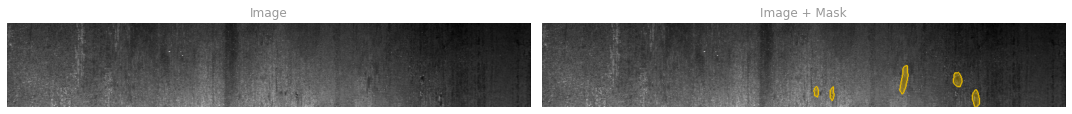

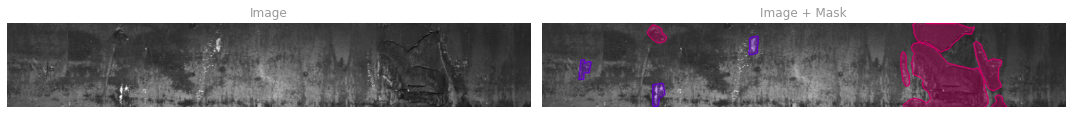

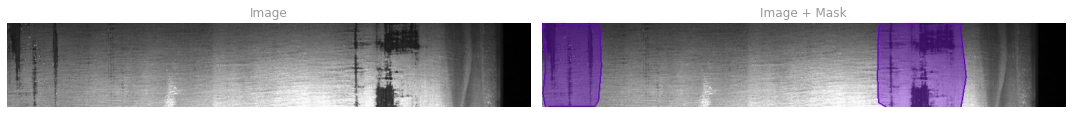

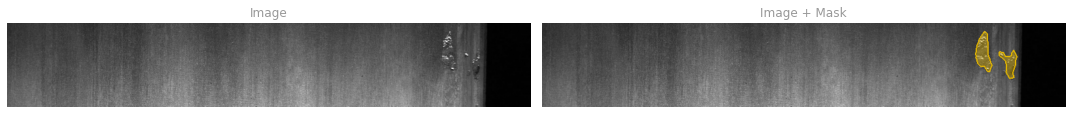

In [ ]:
#@markdown Data Examples
num_examples =  4#@param {type:'raw'}

if num_examples:
    temp_dataset = get_dataset(TFRECS_DEFECT, target_size, 1)
    defect_examples = retrieve_examples(temp_dataset, num_examples*5)

    random.shuffle(defect_examples)
    for example in defect_examples[:num_examples]:
        plot_image_mask(example, height=1.8, mask_rgb = mask_rgb)

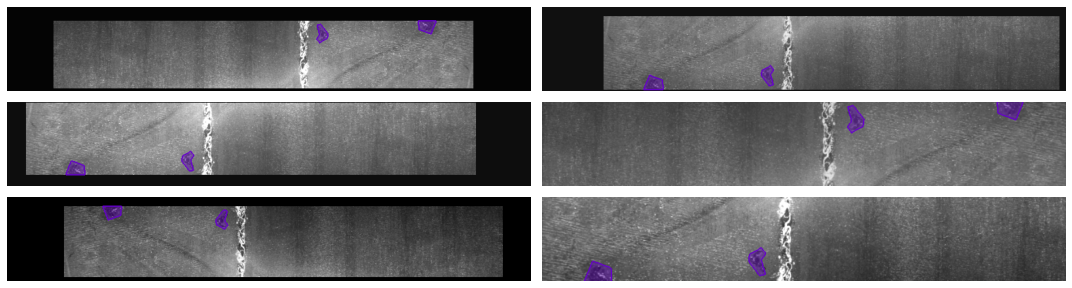

In [ ]:
#@markdown Augmentations
if num_examples:
    n_rows, n_cols = 3, 2
    example = defect_examples[num_examples]
    example = (*example, 1) # add the label (required by data_augment)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 1.4*n_rows))
    for c in range(n_rows*n_cols):   
        image, mask, _ = data_augment(example, target_size, p1=.5, p2=0.5)
        masks = [(contoured_mask(mask[..., c], mask_rgb[c], alpha = 0.4)) for c in range(4)]
        ax = fig.axes[c]
        # np.clip to supress warning. vals outside ranges b/c random brightness, contrast augmentations
        ax.imshow(np.clip(image, 0, 1)) 
        for m in masks:
            ax.imshow(m)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

## Logs and Weights Management


In [ ]:
#@markdown Importing Trained Weights
zip_dest = PROJECT_DIR + 'severstal-fold-1-weights.zip'
if ADD_PRETRAINED: 
    if not os.path.isfile(zip_dest):
        !gdown https://drive.google.com/uc?id=12BWVtZqg0EtWq0J2329ggyR7eK35bycV -O {zip_dest}
    !unzip -qn {zip_dest} -d {weights_dir} 

Downloading...
From: https://drive.google.com/uc?id=12BWVtZqg0EtWq0J2329ggyR7eK35bycV
To: /content/severstal-fold-1-weights.zip
525MB [00:02, 234MB/s]


In [ ]:
#@markdown Weights Management
# Get names of saved weights (if any) in main weights directory
!mkdir -p {weights_dir}discarded/
saved_weights = [w.split('/')[-1] for w in tf.io.gfile.glob(weights_dir+'*.h5')]

weights_metrics = {}
weights_names = {}
for w in saved_weights:
    prefix, sz, _ , metric = w.split('_')
    prefix = '{}_{}'.format(prefix, sz)
    metric_float = float(metric.split('.')[0])*10e-6
    if not prefix in weights_metrics:
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    elif metric_float > weights_metrics[prefix]:
        !mv {weights_dir}{weights_names[prefix]} {weights_dir}discarded/
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    else: 
        !mv {weights_dir}{w} {weights_dir}discarded/

def check_and_save(history, model, fold_num, img_size, metric, metric_abbr = 'acc',
                   current_wname = 'weights.h5', weights_dir=weights_dir):
    current_metric = max(history.history[metric])
    size_str = str(img_size[0]) + 'x' + str(img_size[1])
    prefix = '{}-f{}_{}'.format(model.name.lower(), fold_num, size_str)
    metric_str = str(current_metric*10e4)[:5]
    weights_name = '{}_{}_{}.h5'.format(prefix, metric_abbr, metric_str)
    if not prefix in weights_metrics or current_metric >= weights_metrics[prefix]: 
        weights_names[prefix] = weights_name
        if prefix in weights_metrics:
            !mv {weights_dir}{prefix}* {weights_dir}discarded/
        !cp {current_wname} {weights_dir}{weights_name}
        weights_metrics[prefix] = current_metric
        saved_weights.append(weights_name)
    return None

def create_df_row(w):
    # w: (str) is the filename of the saved weights
    base, size, _, score = w.split('_')
    key_id = '{}_{}'.format(base, size)
    score = float(score.split('.')[0])*10e-6
    size = eval(size.replace('x', ', '))
    base, efn_ver, model_type, fold_num = base.split('-')
    metric = 'accuracy' if 'bin' in model_type else 'dice'
    model_type = 'binary' if 'bin' in model_type else 'segmentation'
    backbone, fold_num = base+efn_ver, int(fold_num[1])
    return [key_id, backbone, fold_num, size, score, metric, model_type, w]

def get_best_weights(df, n_per_fold = 5, sort_by_col = 'score', 
                     group_by_col = 'fold', mode = 'max'):
    m = df.groupby(group_by_col)[sort_by_col]
    m = m.nlargest(n_per_fold) if mode == 'max' else m.nsmallest(n_per_fold)
    try: idxs = [i[1] for i in m.index]
    except: idxs = [i for i in m.index]
    return df.loc[idxs].reset_index(drop=True)

In [ ]:
#@markdown Existing Weights
col_names = ['key', 'base', 'fold', 'size', 'score', 'metric', 'model_type', 'filename']
bin_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
seg_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 

weights_df = pd.DataFrame(bin_rows + seg_rows, columns = col_names)
display(weights_df[col_names[:7]])

,key,base,fold,size,score,metric,model_type
0,efficientnet-b1-bin-f1_128x800,efficientnetb1,1,"(128, 800)",0.98252,accuracy,binary
1,efficientnet-b3-bin-f1_128x800,efficientnetb3,1,"(128, 800)",0.98332,accuracy,binary
2,efficientnet-b0-bin-f1_128x800,efficientnetb0,1,"(128, 800)",0.98173,accuracy,binary
3,efficientnet-b5-bin-f1_128x800,efficientnetb5,1,"(128, 800)",0.98292,accuracy,binary
4,efficientnet-b3-unetpp-f1_128x800,efficientnetb3,1,"(128, 800)",0.71315,dice,segmentation
5,efficientnet-b4-unetpp-f1_128x800,efficientnetb4,1,"(128, 800)",0.71082,dice,segmentation
6,efficientnet-b5-unetpp-f1_128x800,efficientnetb5,1,"(128, 800)",0.71729,dice,segmentation


# Training

## Binary Model

In [ ]:
EPOCHS = 20
metric_monitor = performance_monitor('val_accuracy', 'max')
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

imgs_per_replica = 32
lr_params =  [3e-3,  3e-3,  1e-6, 3, 4, 8e-1]
lr_sched = lr_schedule_builder(lr_params)
if TRAINING:  
    !pip -q install tensorflow_addons >/dev/null
    import tensorflow_addons as tfa
    radam = tfa.optimizers.RectifiedAdam()

Specify folds and EfficientNet version to train in the training loop. 
May need to reduce `imgs_per_replica` for more complex EfficientNet versions and/or larger `target_size`. 

In [ ]:
folds_to_train = [1] 
efficientnet_versions = [0, 1]

In [ ]:
if TRAINING:    
    for training_fold in folds_to_train:
        print(hline +'\nDataset for FOLD {} with image size {}\n'.format(
            training_fold, target_size) + hline)
        datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 
                                    'label', use_unmasked = True)
        train_steps = int(steps['train']*1.25) # steps were added due to over-sampling

        for efn_ver in efficientnet_versions:
            base_model = 'EfficientNet-B{}'.format(efn_ver)
            print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                base_model, training_fold, target_size) + hline)

            with strategy.scope(): 
                model = build_classifier(base_model, n_classes = 1, input_shape = INPUT_SHAPE, 
                                        weights = 'imagenet', name_suffix='-bin')
                model.compile(optimizer=radam, loss=loss, metrics=['accuracy', 'AUC']) 

            train_begin = time()
            checkpoint = config_checkpoint(monitor ='val_accuracy', mode = 'max')
            history = model.fit(datasets['train'], steps_per_epoch= train_steps,
                                epochs= EPOCHS, verbose=0, 
                                callbacks=[lr_sched, metric_monitor, checkpoint],
                                validation_data=datasets['valid'])
            
            check_and_save(history, model, training_fold, target_size, 'val_accuracy', 'acc')
            print(hline+'\nTime to train {} epochs: {}'.format(EPOCHS, time_passed(train_begin)))
            del model
            K.clear_session()

    del training_fold, datasets, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
Dataset for FOLD 1 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((256, 128, 800, 3), (256,)), types: (tf.float32, tf.int32)
Unique train examples per epoch 10050 
Total valid examples 2518
───────────────────────────────────────────────────────────────────────────────────
Training EfficientNet-B0 on FOLD 1 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_accuracy improved from -inf to 0.8042
New best at Epoch 002 val_accuracy improved from 0.8042 to 0.8332
New best at Epoch 003 val_accuracy improved from 0.8332 to 0.9142
New best at Epoch 004 val_accuracy improved from 0.9142 to 0.9384
New best at Epoch 007 val_accuracy improved from 0.9384 to 0.9508
New best at Epoch 009 val_accuracy improved from 0.9508 to 0.9571
New best at E

## Segmentation Model

The segmentation components all consist of Unet++ networks with EfficientNet encoders. 

**Two training strategies were used as follows.**

1. Train 30 epochs with `lr_sched_1` learning rate schedule using `bce_dice_loss` and Nadam optimizer. 
2. Train 20 epochs with `lr_sched_1` learning rate schedule using `focal_dice`  loss and Nadam optimizer. Then fine tune for 15 epochs using `lr_sched_2` learning rate schedule and switching to `dice_loss` and Adam optimizer. 

**Only the latter is presented here.**

The 1st strategy seemed better at drawing mask boundaries between defected pixels and non-defected pixels (i.e. tighter masks around a found defect). 

The 2nd strategy appeared to perform better at distinguishing between the types of defects; it did exceptionally well at distinguishing the rarer classes 1 and 2 from the most common class 3. Whereas the 1st strategy regularly detected the defect but more often mislabeled the class.

In terms of overall Dice coefficient, it was seen that an ensemble including components trained using both strategies scored better than those that included components trained using only one strategy. 

However, I would consider components trained using the 2nd strategy more useful. Although less precise mask boundaries invariably lower the Dice score, their ability to detect defects and correctly classify their class appeared to be superior in practical terms. This could be particularly true if we consider that there may be a considerable degree of subjectivity on the “ground-truth” mask boundaries, as opposed to the more objective “existence” of the defect or the class of the defect . 


In [ ]:
#@markdown Segmentation Losses & Metrics
if TRAINING:  
    !pip install -qU segmentation-models
    os.environ['SM_FRAMEWORK'] = 'tf.keras'
    from segmentation_models import losses
    focal_dice = losses.binary_focal_dice_loss 

def dice_coefficient(y_true, y_pred, smooth=1.):
    # compatible with evaluation in prediction loop
    smooth = tf.constant(smooth)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    denom = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth
    dice = (tf.constant(2.) * intersection + smooth)/denom
    return dice

# redefining existing metrics to reduce verbosity
def dice(y, p): return dice_coef(y, p)
def adice(y, p): return dice_avg(y, p)
def chdice(y, p): return channel_avg_dice(y, p)

Segmentation Models: using `tf.keras` framework.


In [ ]:
EPOCHS_1 = 20
EPOCHS_2 = 15
EPOCHS_TOT = EPOCHS_1 + EPOCHS_2

lr_params_1 =  [3e-3,  3e-3,  1e-6, 2, 4, 8e-1]
lr_sched_1 = lr_schedule_builder(lr_params_1)

lr_params_2 =  [2e-4,  2e-4,  1e-6, 0, EPOCHS_1, 8e-1]
lr_sched_2 = lr_schedule_builder(lr_params_2) 

nadam = tf.keras.optimizers.Nadam()
adam = tf.keras.optimizers.Adam()

metrics = [dice, adice, chdice]

imgs_per_replica = 8 
metric_monitor = performance_monitor('val_chdice', 'max')

Specify folds and EfficientNet versions to train in the training loop. 
May need to reduce `imgs_per_replica` for more complex EfficientNet versions and/or larger `target_size`. 

In [ ]:
folds_to_train = [1] 
efficientnet_versions = [0, 3]

In [ ]:
if TRAINING:  
    for training_fold in folds_to_train:
        print(hline +'\nDataset for FOLD {} with image size {}\n'.format(
            training_fold, target_size) + hline)
        datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 'mask', 
                                    use_unmasked = 'train', p_undersample = 0.90)
        train_steps = int(steps['train']*1.30) # steps were added due to over-sampling

        for efn_ver in efficientnet_versions:
            backbone_name = 'EfficientNet-B{}'.format(efn_ver)
            print(hline +'\nTraining Unet++ with {} backbone on FOLD {} with image size {}\n'.format(
                backbone_name, training_fold, target_size) + hline)
            with strategy.scope(): 
                model = xnet(backbone_name, N_DEFECT_CLASSES, INPUT_SHAPE, weights='imagenet')
                model.compile(optimizer=nadam, loss=focal_dice, metrics = metrics) 

            train_begin = time()
            checkpoint = config_checkpoint(monitor ='val_adice', mode = 'max')
            history = model.fit(datasets['train'], steps_per_epoch= train_steps,
                                epochs= EPOCHS_1, verbose=0, 
                                callbacks=[lr_sched_1, metric_monitor, checkpoint],
                                validation_data=datasets['valid'])
            
            print('\nFine tuning with Dice Loss and Adam')
            with strategy.scope():
                model.compile(optimizer=adam, loss=dice_loss, metrics = metrics) 

            history = model.fit(datasets['train'], steps_per_epoch = train_steps,
                                epochs = EPOCHS_TOT, initial_epoch = EPOCHS_1, verbose=0, 
                                callbacks=[lr_sched_2, metric_monitor, checkpoint],
                                validation_data=datasets['valid'])

            check_and_save(history, model, training_fold, target_size, 'val_adice', 'adice')
            print(hline+'\nTime to train {} epochs: {}'.format(EPOCHS_TOT, time_passed(train_begin)))

            del model
            K.clear_session()

    del training_fold, datasets, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
Dataset for FOLD 1 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((64, 128, 800, 3), (64, 128, 800, 4)), types: (tf.float32, tf.float32)
Unique train examples per epoch 5802 approx
Total valid examples 1336
───────────────────────────────────────────────────────────────────────────────────
Training Unet++ with EfficientNet-B0 backbone on FOLD 1 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_chdice improved from -inf to 0.0405
New best at Epoch 002 val_chdice improved from 0.0405 to 0.1772
New best at Epoch 003 val_chdice improved from 0.1772 to 0.3887
New best at Epoch 004 val_chdice improved from 0.3887 to 0.5838
New best at Epoch 006 val_chdice improved from 0.5838 to 0.6285
New best at Epoch 009 val_chdice improved from 0.62

# Evaluation

In [ ]:
#@markdown Load Trained Model, Assemble Ensemble Functions

def load_pretrained_model(weights_id, compile_model = True, opt = [], 
                          loss = 'default', metrics = 'default', details = []):
    
    prefix, size = weights_id.split('_')
    size = eval(size.replace('x', ', '))
    base, base_ver, model_type, _  = prefix.split('-')
    wname = weights_names[weights_id]
    weights_path = weights_dir + wname

    # Import weights to colab (if elsewhere) to avoid "bad symbol" errors
    if not os.path.isfile('./weights/' + wname):
        !cp {weights_path} ./weights/{wname}
    weights_path = './weights/' + wname

    base_name = base + base_ver

    if 'bin' in model_type: builder = build_classifier
    elif 'unetpp' in model_type: builder = xnet
    elif 'unet' in model_type: builder = unet

    if compile_model:
        if 'bin' in model_type:
            if metrics == 'default': metrics = ['accuracy', 'AUC']
            if loss == 'default': loss = 'binary_crossentropy'
        elif 'unet' in model_type:
            if metrics == 'default': metrics = [dice_coef, dice_avg]
            if loss == 'default': loss = [bce_dice_loss]
        
    if 'bin' in model_type: n_classes = 1 
    else: n_classes = 4 

    with strategy.scope():
        model = builder(base_name, n_classes, input_shape=(*size, 3), weights = None)
        model.load_weights(weights_path)
        if compile_model:
            model.compile(optimizer=opt, loss=loss, metrics=metrics)
            
    if len(details) > 0: 
        scope = locals()
        return (model, *[eval(d, scope) for d in details])
    else: return model

def determine_outter_size(weights_keys):
    sizes = [eval(k.split('_')[-1].replace('x', ', ')) for k in weights_keys]
    areas = [s[0]*s[1] for s in sizes]
    return sizes[np.argmax(areas)]

def assemble_ensemble(weights_ids, outter_size = 'auto', ensemble_type = 'auto', 
                      metrics = 'default', loss = 'default', details = []):
    if outter_size == 'auto': outter_size = determine_outter_size(weights_ids)
    if ensemble_type == 'auto': 
        ensemble_type = 'segmentation' if 'unet' in weights_ids[0] else 'binary'

    ensemble_outputs = []
    resized_inputs = {}
    with strategy.scope():
        x = L.Input(shape=(*outter_size, 3))
        for i, w in enumerate(weights_ids):
            model, size = load_pretrained_model(w, compile_model = False, details = ['size'])
            model._name = '{}-M{}'.format(model.name, i)
            if size == outter_size:
                model_output = model(x)
            else:
                if not str(size) in resized_inputs: 
                    resized_inputs[str(size)] = tf.image.resize(x, size)
                model_output = model(resized_inputs[str(size)])
                if ensemble_type == 'segmentation':
                    model_output = tf.image.resize(model_output, outter_size)

            ensemble_outputs.append(model_output)

        y = L.Average(name = 'Simple_Average')(ensemble_outputs)

        if metrics == 'default':
            if ensemble_type == 'segmentation': metrics = [dice_coef, dice_avg] 
            else: metrics = ['accuracy', 'AUC']

        if loss == 'default':
            if ensemble_type == 'segmentation': loss = [bce_dice_loss]
            else: loss = 'binary_crossentropy'

        name = '{}_Ensemble'.format(ensemble_type.title())
        ensemble = tf.keras.Model(inputs=x, outputs=y, name=name)
        ensemble.compile(optimizer=[], loss=loss, metrics=metrics)
    
    if len(details) > 0: 
        scope = locals()
        return (ensemble, *[eval(d, scope) for d in details])
    else: return ensemble

eval_temp_fix = lambda model, ds: model.evaluate(ds, steps = 1, verbose = 0)[3:]
# current TF version has a documented issue in which the first evaluation after 
# using model.load_weights() is not accurate. This "fix" circumvents the issue.

In [ ]:
#@markdown Evaluation Datasets
def data_meta(filenames, vars = ('img_id', 'label')):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(lambda x: read_tfrecord(x, vars = vars), 
                          num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

def get_eval_datasets(fold_num, target_size = (128, 800), target_var = 'mask', 
                      imgs_per_replica = 8, augment = False, repeat = False):
    '''
    Returns Datasets for evaluation, they are ordered, do not drop remainder. 
    Augmentations and Repeat if requested. 
    '''
    batch_size = imgs_per_replica * N_REPLICAS
    tfrec_lists = get_fold_file_lists(fold_num, use_unmasked = True)
    create_ds = lambda fnames: get_dataset(fnames, target_size, batch_size, target_var, 
                                           augment = augment, repeat = repeat, ordered = True)
    keys = 'train', 'valid'
    datasets = {k: create_ds(tfrec_lists[i]) for i, k in enumerate(keys)}
    counts = {k: count_data_items(tfrec_lists[i]) for i, k in enumerate(keys)}
    min_steps = {k: np.ceil(counts[k]/batch_size).astype(int) for k in counts }
    meta_datasets = {k: data_meta(tfrec_lists[i]) for i, k in enumerate(keys)}
    return datasets, counts, min_steps, meta_datasets

Select fold to evaluate and the number of ensemble components for binary classification and segmentation.

In [ ]:
fold_num = 1
binary_ensemble_size = 4
segmentation_ensemble_size = 3

## Binary Model Evaluation

In [ ]:
#@markdown Select Binary Ensemble Weights 
bin_df_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
bin_df = pd.DataFrame(bin_df_rows, columns = col_names)

best_bin = get_best_weights(bin_df, binary_ensemble_size)
best_bin_fold = best_bin[best_bin.fold==fold_num]
bin_keys = best_bin_fold.key.values

print('Binary Ensemble Components:')
display(best_bin_fold[col_names[1:7]])

Binary Ensemble Components:


,base,fold,size,score,metric,model_type
0,efficientnetb3,1,"(128, 800)",0.98332,accuracy,binary
1,efficientnetb5,1,"(128, 800)",0.98292,accuracy,binary
2,efficientnetb1,1,"(128, 800)",0.98252,accuracy,binary
3,efficientnetb0,1,"(128, 800)",0.98173,accuracy,binary


In [ ]:
model = load_pretrained_model(bin_keys[0])
dsets_bin, counts, steps, meta_dsets = get_eval_datasets(fold_num, target_size, 'label')

In [ ]:
start_retrive_meta = time()
meta_list = []
for item in meta_dsets['valid']:
    meta_list.append([i.numpy() for i in item])

meta_df = pd.DataFrame(meta_list, columns = ['ImageId', 'label'])
del meta_list
print('Time to build metadata from tfrecs: {}'.format(time_passed(start_retrive_meta)))

Time to build metadata from tfrecs: 00:08


<h3> Accuracy of the single best classifier </h3>

In [ ]:
eval_temp_fix(model, dsets_bin['valid'])

print('Evaluating on validation data')
_ = model.evaluate(dsets_bin['valid'])

print('\nEvaluating on train data')
_ = model.evaluate(dsets_bin['train'])

del model; K.clear_session()

Evaluating on validation data
40/40 [==============================] - 6s 108ms/step - loss: 0.0742 - accuracy: 0.9825 - auc: 0.9959

Evaluating on train data
158/158 [==============================] - 23s 133ms/step - loss: 0.0331 - accuracy: 0.9989 - auc: 1.0000


<h3> Binary classification ensemble

In [ ]:
binary_ensemble = assemble_ensemble(bin_keys)
_ = eval_temp_fix(binary_ensemble, dsets_bin['valid'])
binary_ensemble.summary()

Model: "Binary_Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 800, 3) 0                                            
__________________________________________________________________________________________________
Efficientnet-B3-M0 (Functional) (None, 1)            10785065    input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B5-M1 (Functional) (None, 1)            28515569    input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B1-M2 (Functional) (None, 1)            6576513     input_1[0][0]                    
____________________________________________________________________________________

In [ ]:
print('Evaluating on validation data')
_ = binary_ensemble.evaluate(dsets_bin['valid'])

Evaluating on validation data
40/40 [==============================] - 9s 185ms/step - loss: 0.0673 - accuracy: 0.9845 - auc: 0.9980


In [ ]:
preds = binary_ensemble.predict(dsets_bin['valid'], verbose=1)
print('Number of Predictions: ', preds.shape[0])
meta_df['preds_prob'] = np.squeeze(preds)
del binary_ensemble

40/40 [==============================] - 37s 171ms/step
Number of Predictions:  2518


<h3> Classification Report for Binary Ensemble </h3>

In [ ]:
targets, preds_prob = meta_df.label.values, meta_df.preds_prob.values

In [ ]:
_, cm, metrics_strings = performance_metrics(targets, preds_prob, report_type = 'total')
table_string = metrics_table_html_string(metrics_strings)
cm_string = confusion_matrix_html(cm, classes, False, '(Full Validation Data)')
display(HTML(html_report_base % (cm_string, table_string)))

<h2> Binary Classification Experiments </h2>

Below are some experiments in which more ambiguous examples (i.e. those within some lower and upper probability thresholds) are excluded from the predictions. Examples inside the thresholds are deemed inconclusive and only those outside the thresholds are considered predicted. 

Although the thresholds values are highly overfitted to the current validation data, the ability to generate high rates of very high confidence predictions with corresponding low inconclusive rates I expect should be quite generalizable beyond the current validation data.

In [ ]:
#@markdown Adjusting prediction thresholds to limit results to higher confidence predictions.
pos_thresh = 0.65 #@param {type:"number"}
neg_thresh = 0.35 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = confusion_matrix_html(cm, classes, False, '(High Confidence Thresholds)')
display(HTML(html_report_base % (cm_string, table_string)))

In [ ]:
#@markdown Adjusting prediction thresholds to minimize False Nagatives.
pos_thresh = 0.80 #@param {type:"number"}
neg_thresh = 0.03 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = confusion_matrix_html(cm, classes, False, '(Minimizing False Negatives)')
display(HTML(html_report_base % (cm_string, table_string)))

In [ ]:
#@markdown Adjusting prediction thresholds to minimize misclassification.
pos_thresh = 0.96 #@param {type:"number"}
neg_thresh = 0.03 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')
table_string = metrics_table_html_string(metrics_strings)
cm_string = confusion_matrix_html(cm, classes, False, '(Minimizing Misclassification)')
display(HTML(html_report_base % (cm_string, table_string)))

# Segmentation Model Evaluation

In [ ]:
#@markdown Select Segmentation Ensemble Weights
seg_df_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 
seg_df = pd.DataFrame(seg_df_rows, columns = col_names)

best_seg = get_best_weights(seg_df, segmentation_ensemble_size)
best_seg_fold = best_seg[best_seg.fold==fold_num]
seg_keys = best_seg_fold.key.values

print('Segmentation Ensemble Components:')
display(best_seg_fold[col_names[1:7]])

Segmentation Ensemble Components:


,base,fold,size,score,metric,model_type
0,efficientnetb5,1,"(128, 800)",0.71729,dice,segmentation
1,efficientnetb3,1,"(128, 800)",0.71315,dice,segmentation
2,efficientnetb4,1,"(128, 800)",0.71082,dice,segmentation


In [ ]:
segmentation_ensemble = assemble_ensemble(seg_keys)
segmentation_ensemble.summary()

Model: "Segmentation_Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 800, 3) 0                                            
__________________________________________________________________________________________________
Efficientnet-B5-UnetPP-M0 (Func (None, 128, 800, 4)  40883700    input_6[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B3-UnetPP-M1 (Func (None, 128, 800, 4)  21347628    input_6[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B4-UnetPP-M2 (Func (None, 128, 800, 4)  29036892    input_6[0][0]                    
______________________________________________________________________________

<h3> Mask Prediction Loop </h3> 

The following applies some post-processing techniques to the ensemble predictions before it computes the Dice coefficient for each type of defect for each image, then calculate the average. Unlike the Dice coefficient used during training, this loop uses images with and without defects. This calculation is the most relevant metric to the Severstal Challenge.

Below, the TPU would be able to make all predictions at once but post-processing requires raw predictions to be available for the CPU, which would exhaust memory. Thus, the validation dataset used is divided into `n_parts`, which will still be predicted using the TPU, and temporarily stored in numpy arrays for post-processing using CPU, but on smaller amounts of data.








In [ ]:
n_parts = 3
dsets, counts, steps, _ = get_eval_datasets(fold_num, target_size, 'mask')
valid_ds_parts = split_dataset(dsets['valid'], steps['valid'], n_parts = n_parts)

In [ ]:
meta_dict = meta_df.to_dict()
empty_mask = np.zeros(target_size, int) 
n_demo =  200 # will keep some examples to show prediction examples

**Post-Processing Parameters**

Post-processing is done by: 
1. Using the binary predictions to determine if the image has any defect. Images with probability below `binary_thresh` will be predicted to have empty masks for all types of defects. 
2. Gathering high confidence mask predictions as determined by `thresh_upper`, making sure the high confidence area meets the minimum area requirements according to `min_area`. 
3. Once the image "passed" the binary and minimum high confidence mask area "tests", all mask predictions with probabilities above a low threshold, as indicated by `thresh_lower` will be determined to be part of a detected defect. 

In [ ]:
binary_thresh = 0.55
thresh_upper = [0.7,0.7,0.7,0.7]
thresh_lower = [0.4,0.5,0.4,0.5]
min_area     = [180, 260, 200, 500]

In [ ]:
demo_preds = []; 
dices = [], [], [], []; 
i = 0; 
start_preds = time()
for p, ds_part in enumerate(valid_ds_parts):
    print('\nPredicting and processing part {} of {}'.format(p+1, n_parts))
    preds = segmentation_ensemble.predict(ds_part, verbose = 1)
    gt_masks = [m.numpy().squeeze() for m in ds_part.map(lambda x, y: y).unbatch()]
    print('Shape of predictions part {}: {}'.format(p+1, preds.shape))
    for gt_mask, pred in zip(gt_masks, preds):
        pred_mask = np.zeros(pred.shape, int)
        demo = False
        if meta_dict['preds_prob'][i]  > binary_thresh:
            for ch in range(N_DEFECT_CLASSES):
                ch_truth = gt_mask[..., ch]
                ch_probs = pred[..., ch]
                ch_pred = (ch_probs > thresh_upper[ch]).astype(int)
                if ch_pred.sum() < min_area[ch]: ch_pred = empty_mask
                else:
                    ch_pred = (ch_probs > thresh_lower[ch]).astype(int)
                    pred_mask[..., ch] = ch_pred
                    demo = True
                dc = dice_coefficient(ch_truth, ch_pred)
                dices[ch].append(dc.numpy())
        else:
            for ch in range(N_DEFECT_CLASSES):
                ch_truth = gt_mask[..., ch]
                dc = dice_coefficient(ch_truth, empty_mask)
                dices[ch].append(dc.numpy())
        if demo and len(demo_preds) < n_demo: demo_preds.append([i, gt_mask, pred_mask])
        i += 1
    del preds, gt_masks, pred, gt_mask

print('\nElapsed time {}'.format(time_passed(start_preds)))
print('Average Dice coefficient:', np.mean(dices))
ch_dices = ['Class {}: {:.4f}'.format(i+1, dc) for i, dc in zip(range(4), [np.mean(d) for d in dices])]
print('\nAverage Dice coefficient per type of defect: ', (4*'\n{}').format(*ch_dices))


Predicting and processing part 1 of 3
14/14 [==============================] - 73s 752ms/step
Shape of predictions part 1: (896, 128, 800, 4)

Predicting and processing part 2 of 3
14/14 [==============================] - 13s 748ms/step
Shape of predictions part 2: (896, 128, 800, 4)

Predicting and processing part 3 of 3
12/12 [==============================] - 13s 761ms/step
Shape of predictions part 3: (726, 128, 800, 4)

Elapsed time 05:05
Average Dice coefficient: 0.95326436

Average Dice coefficient per type of defect:  
Class 1: 0.9725
Class 2: 0.9889
Class 3: 0.8701
Class 4: 0.9816


### Visualize Ground-Truth vs. Predictions

In [ ]:
#@markdown Retrieve demo images
images_ds = dsets['valid'].map(lambda x, y: x).unbatch()
masked_idxs = [p[0] for p in demo_preds]
imgs = []
for i, img in enumerate(images_ds):
    if i in masked_idxs: 
        imgs.append(img)
        if len(imgs) == n_demo: break

demo_tuples = [(imgs[i], d[1], d[2]) for i, d in enumerate(demo_preds)]

In [ ]:
#@markdown Plot ground-truth vs. prediction function
def plot_gt_vs_pred(pred_demo):
    fig, axs = plt.subplots(2, 1, figsize=(12, 3))
    rgb_colors = mask_rgb
    titles = 'Ground Truth', 'Prediction'
    for x, title in enumerate(titles):
        ax = fig.axes[x]
        ax.imshow(pred_demo[0])
        mask = pred_demo[x+1]
        masks = [(contoured_mask(mask[..., c], rgb_color = rgb_colors[c], 
                                 alpha=0.3)) for c in range(mask.shape[-1])]
        [ax.imshow(m, alpha = 1) for m in masks]
        ax.axis('off')
        ax.set_title(title, fontdict={'fontsize': 13})
    plt.tight_layout()
    plt.show()
    return None

In [ ]:
display(colors_html)

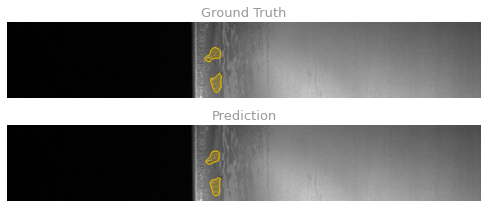

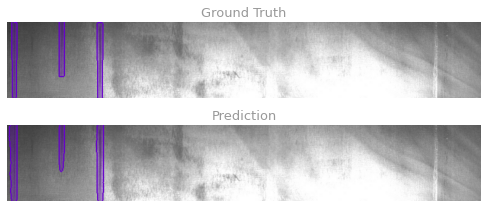

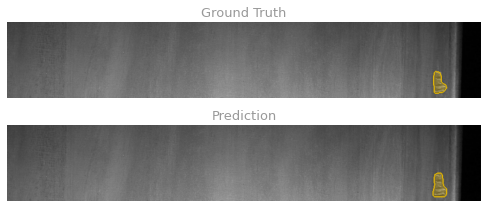

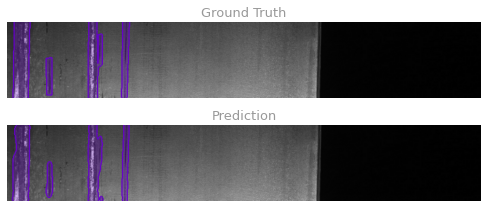

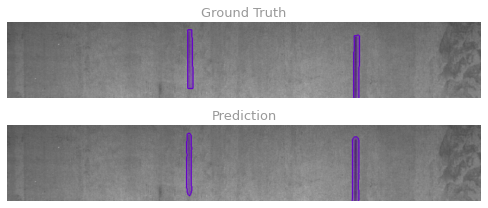

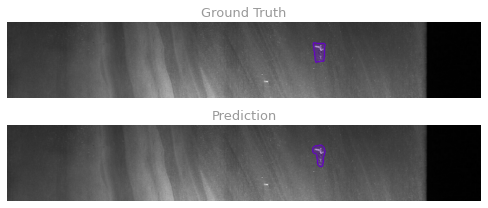

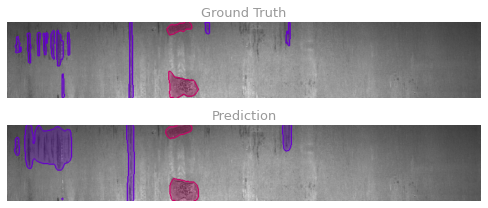

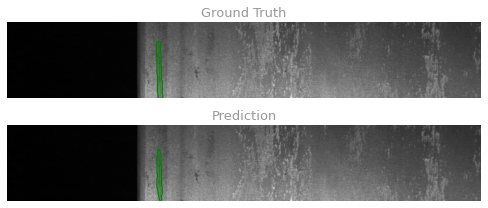

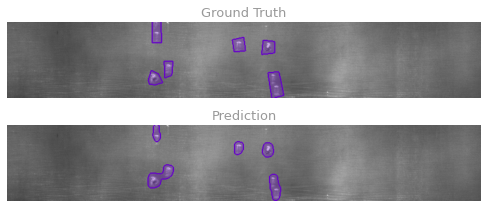

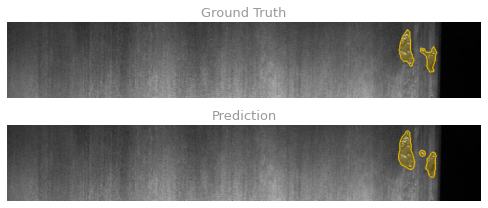

In [ ]:
#@markdown Random Examples  
for i in np.random.choice(n_demo, 10, replace=False):
    plot_gt_vs_pred(demo_tuples[i])

In [ ]:
#@markdown Runtime
print('Time to run notebook: ', time_passed(start_notebook))
print('Notebook finished at:', current_time_str())

Time to run notebook:  01:45:52
Notebook finished at: 09:55 PM


### Conclusion

This notebook presented a system of neural networks ensembles to detect defects on images of steel. 

The system consisted of  2 parts: 

-	The first was a binary classification ensemble using EffficientNet based classifiers which aimed at distinguishing between images with no defects and images with any kind of defect. The main metric used here was accuracy. The ensemble and it’s individual components consistently achieved over 98 percent accuracy on the full validation data. 
-	The second was a segmentation ensemble using the Unet++ model with EfficientNet based encoders aimed at detection the location, area, and type of defect. The main metric was class-wise average dice score, as stipulated by the [Severstal: Steel Defect Detection]( https://www.kaggle.com/c/severstal-steel-defect-detection) challenge. 

A system based on this approach achieves a Dice coefficient of 0.90229 in Severstal's private test data, on par with the top 3% of the results of the challenge.













# References:

- Tan, M., & Le, Q. V. (2020). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. [arXiv:1905.11946v5](https://arxiv.org/abs/1905.11946v5).

- Zhou, Z., Siddiquee, M., Tajbakhsh, N., & Liang, J. (2019). UNet++: Redesigning Skip Connections to Exploit Multiscale Features in Image Segmentation. [arXiv:1912.05074v2](https://arxiv.org/abs/1912.05074v2).